In [154]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import credit_card_data

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from random import shuffle
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [68]:
window_size = 12

Z,Y = credit_card_data.generate_raw_data(36,50000)
train_data, train_label, test_data, test_label = credit_card_data.generate_win_data(Z, Y, window_size)
train_data = torch.tensor(train_data, dtype=torch.float)
train_label = torch.tensor(train_label, dtype=torch.float)
test_data = torch.tensor(test_data, dtype=torch.float)
test_label = torch.tensor(test_label, dtype=torch.float)

In [58]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [182]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=3, num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        print(input.view(input.size()[0],1,input.size()[1]).size())
        lstm_out, hidden = self.lstm(input.view(input.size()[0],1,input.size()[1]))
        print(lstm_out.size())
        y_pred = self.linear(lstm_out)
        y_pred = self.sigmoid(y_pred)
        return y_pred

In [189]:
num_epochs = 3
batch_size = 256

lstm_input_size = window_size
h1 = 3
num_train = len(train_data)
output_dim = 1
num_layers = 1
model = LSTM(lstm_input_size, h1, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
model.to(device)

learning_rate = 0.005
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

TypeError: __init__() got an unexpected keyword argument 'batch_first'

## Focal Loss

In [184]:
train_label.shape

torch.Size([263536])

In [185]:
train = np.concatenate([train_data,train_label.unsqueeze(1)],axis = 1)

In [186]:
def train(loss_fn):
    model = LSTM(lstm_input_size, h1, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
    model.cuda()
    for t in range(num_epochs):
        train = np.concatenate([train_data,train_label.unsqueeze(1)],axis = 1)
        shuffle(train)
        train_data_ = torch.tensor(train[:,:12])
        train_label_ = torch.tensor(train[:,12])
        for i in range(len(train_data_)//batch_size):
            
            model.zero_grad()
            y_pred = model(train_data_[i*batch_size:(i+1)*batch_size].to(device))
            loss = loss_fn(y_pred, train_label_[i*batch_size:(i+1)*batch_size].to(device))
            if i % 100 == 0:
                print('epoch: '+str(t)+'\tbatch: '+str(i)+'\tloss: ',loss.item())
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
    return model

In [187]:
loss_2 = FocalLoss()

In [188]:
m = train(loss_2)

torch.Size([256, 1, 12])
torch.Size([256, 1, 3])


D:\anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1, 1])) is deprecated. Please ensure they have the same size.
  del sys.path[0]


epoch: 0	batch: 0	loss:  0.046885982155799866
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12])
torch.Size([256, 1, 3])
torch.Size([256, 1, 12]

KeyboardInterrupt: 

In [162]:
model = LSTM(lstm_input_size, h1, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
model.to(device)
best_model = None
best_loss = float('inf')
for t in range(num_epochs):
    train = np.concatenate([train_data,train_label.unsqueeze(1)],axis = 1)
    shuffle(train)
    train_data_ = torch.tensor(train[:,:12])
    train_label_ = torch.tensor(train[:,12])
    for i in range(len(train_data_)//batch_size):
#         model.zero_grad()
        y_pred = model(train_data_[i*batch_size:(i+1)*batch_size].to(device))
        weight = np.ones(batch_size)
        for j in range(len(train_label_[i*batch_size:(i+1)*batch_size])):
            if train_label_[i*batch_size:(i+1)*batch_size][j] == 1:
                weight[j] = 2
        weight = torch.tensor(weight,dtype = torch.float).to(device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, train_label_[i*batch_size:(i+1)*batch_size].to(device))
        if i % 250 == 1:
            print('epoch: '+str(t)+'\tbatch: '+str(i)+'\tloss: ',loss.item())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

epoch: 0	batch: 1	loss:  0.8911981582641602
epoch: 0	batch: 251	loss:  0.8985716700553894
epoch: 0	batch: 501	loss:  0.8964217901229858
epoch: 0	batch: 751	loss:  0.8964589834213257
epoch: 0	batch: 1001	loss:  0.8985828757286072
epoch: 1	batch: 1	loss:  0.8867354989051819
epoch: 1	batch: 251	loss:  0.8905588388442993
epoch: 1	batch: 501	loss:  0.8960592150688171
epoch: 1	batch: 751	loss:  0.8970898985862732
epoch: 1	batch: 1001	loss:  0.9004513025283813
epoch: 2	batch: 1	loss:  0.893153190612793
epoch: 2	batch: 251	loss:  0.8917361497879028
epoch: 2	batch: 501	loss:  0.8914210796356201
epoch: 2	batch: 751	loss:  0.8941531181335449
epoch: 2	batch: 1001	loss:  0.8943278789520264


In [163]:
recall = []
precision = []
y_test = model(test_data.to(device)).cpu()
for t in range(1000):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    threshold = t*0.001
    TP += ((y_test > threshold).numpy().reshape(1,-1).flatten()&(test_label == 1).numpy()).sum()
    TN += ((y_test < threshold).numpy().reshape(1,-1).flatten()&(test_label == 0).numpy()).sum()
    FP += ((y_test > threshold).numpy().reshape(1,-1).flatten()&(test_label == 0).numpy()).sum()
    FN += ((y_test < threshold).numpy().reshape(1,-1).flatten()&(test_label == 1).numpy()).sum()
    recall.append((TP) / (TP + FN))
    precision.append((TP) / (TP + FP))

D:\anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


(0, 1)

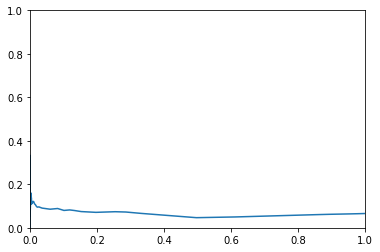

In [164]:
plt.plot(recall,precision)
plt.xlim(0,1)
plt.ylim(0,1)